In [ ]:
# ============================================================================
# 1: Install Dependencies
# ============================================================================

!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install -q transformers>=4.37.0
!pip install -q datasets
!pip install -q peft
!pip install -q bitsandbytes
!pip install -q accelerate
!pip install -q sentencepiece
!pip install -q protobuf
!pip install -q pandas numpy matplotlib seaborn

print(" All dependencies installed successfully!")

 All dependencies installed successfully!


In [ ]:
# ============================================================================
# 2: Import Libraries and Check GPU
# ============================================================================

import json
import csv
import random
import os
import re
from pathlib import Path
from typing import List, Dict, Tuple
import pandas as pd
import numpy as np
from tqdm import tqdm
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
    BitsAndBytesConfig
)
from peft import LoraConfig, get_peft_model, PeftModel, prepare_model_for_kbit_training
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Check GPU
print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("WARNING: No GPU detected! Training will be very slow.")

Libraries imported successfully!
PyTorch version: 2.8.0+cu126
CUDA available: True
GPU: Tesla T4
GPU Memory: 15.83 GB


In [ ]:
# ============================================================================
# 3: Configuration
# ============================================================================

class Config:
    # Model configuration
    BASE_MODEL = "Qwen/Qwen2.5-3B-Instruct"
    HF_TOKEN = ""  # Add your Hugging Face token if needed

    # Paths (Colab-specific)
    WORK_DIR = "/content/qwen_interviewer_work"
    TRAIN_FILE = f"{WORK_DIR}/train.jsonl"
    EVAL_FILE = f"{WORK_DIR}/eval.jsonl"
    TEST_FILE = f"{WORK_DIR}/test.jsonl"
    ADAPTER_DIR = f"{WORK_DIR}/lora_adapter"
    MERGED_MODEL_DIR = f"{WORK_DIR}/merged_model"
    RESULTS_DIR = f"{WORK_DIR}/evaluation_results"

    # Training parameters
    CTX_LEN = 2048
    LORA_R = 16
    LORA_ALPHA = 32
    LORA_DROPOUT = 0.05
    BATCH_SIZE = 2
    GRADIENT_ACCUMULATION_STEPS = 8
    MAX_STEPS = 2000
    WARMUP_STEPS = 100
    LEARNING_RATE = 2e-4
    EVAL_STEPS = 50
    LOGGING_STEPS = 10
    SAVE_STEPS = 50

    # Data split ratios
    TRAIN_RATIO = 0.8
    EVAL_RATIO = 0.1
    TEST_RATIO = 0.1

    # Generation parameters
    GEN_KWARGS = {
        "max_new_tokens": 200,
        "temperature": 0.9,
        "top_p": 0.9,
        "top_k": 40,
        "repetition_penalty": 1.05,
        "no_repeat_ngram_size": 3,
        "do_sample": True
    }

    # Self-evaluation parameters
    SELF_EVAL_GEN_KWARGS = {
        "max_new_tokens": 96,
        "temperature": 0.7,
        "top_p": 0.9,
        "top_k": 40,
        "repetition_penalty": 1.05,
        "do_sample": False
    }

# Create directories
os.makedirs(Config.WORK_DIR, exist_ok=True)
os.makedirs(Config.RESULTS_DIR, exist_ok=True)

print("Configuration loaded!")
print(f"Working directory: {Config.WORK_DIR}")
print(f"Base model: {Config.BASE_MODEL}")
print(f"Training steps: {Config.MAX_STEPS}")
print(f"Checkpoints every {Config.SAVE_STEPS} steps")

Configuration loaded!
Working directory: /content/qwen_interviewer_work
Base model: Qwen/Qwen2.5-3B-Instruct
Training steps: 2000
Checkpoints every 50 steps


In [ ]:
# ============================================================================
# 4: Upload Your CSV Data
# ============================================================================

from google.colab import files
import io

print(" Please upload CSV file containing interview data...")
print("Expected columns: domain, question, user_answer, feedback, follow_up_question")
print("-" * 70)

uploaded = files.upload()

if uploaded:
    csv_filename = list(uploaded.keys())[0]
    print(f"\n File '{csv_filename}' uploaded successfully!")

    # Save to Colab storage
    CSV_PATH = f"/content/{csv_filename}"
    print(f" Saved to: {CSV_PATH}")
else:
    print(" No file uploaded!")
    CSV_PATH = None

 Please upload CSV file containing interview data...
Expected columns: domain, question, user_answer, feedback, follow_up_question
----------------------------------------------------------------------


Saving bootstrapped_feedback_followup_combined (1).csv to bootstrapped_feedback_followup_combined (1).csv

 File 'bootstrapped_feedback_followup_combined (1).csv' uploaded successfully!
 Saved to: /content/bootstrapped_feedback_followup_combined (1).csv


In [ ]:
#  ============================================================================
# 5: Data Preparation Functions
# ============================================================================

def prepare_data_splits(csv_path: str) -> Tuple[List[Dict], List[Dict], List[Dict]]:
    """Read CSV and create train/eval/test splits in QWEN chat format."""
    print("\n Processing CSV data...")
    df = pd.read_csv(csv_path, encoding='utf-8')
    print(f"Initial shape: {df.shape}")

    # Merge duplicate columns and standardize
    column_groups = {}
    for col in df.columns:
        col_lower = str(col).lower().strip()
        if col_lower not in column_groups:
            column_groups[col_lower] = []
        column_groups[col_lower].append(col)

    new_df = pd.DataFrame(index=df.index)
    for col_lower, col_list in column_groups.items():
        if len(col_list) > 1:
            print(f"  Merging: {col_list} -> '{col_lower}'")
            merged_series = df[col_list[0]].copy()
            for col in col_list[1:]:
                merged_series = merged_series.fillna(df[col])
            new_df[col_lower] = merged_series
        else:
            new_df[col_lower] = df[col_list[0]]

    df = new_df

    # Create standardized columns
    for col in ['domain', 'question', 'user_answer', 'feedback', 'follow_up_question']:
        if col not in df.columns:
            df[col] = None

    # Map alternative column names
    if 'input' in df.columns:
        df['question'] = df['question'].fillna(df['input'])
        df['user_answer'] = df['user_answer'].fillna(df['input'])
    if 'answer' in df.columns:
        df['user_answer'] = df['user_answer'].fillna(df['answer'])
    if 'source' in df.columns:
        df['domain'] = df['domain'].fillna(df['source'])

    # Clean data
    initial_count = len(df)
    critical = ['question', 'user_answer', 'feedback']
    df = df.dropna(subset=critical)

    for col in critical:
        before = len(df)
        mask = df[col].astype(str).str.strip().str.len() > 0
        df = df[mask]
        removed = before - len(df)
        if removed > 0:
            print(f"  Removed {removed} empty '{col}' rows")

    print(f"\n Valid rows: {len(df)} (removed {initial_count - len(df)})")

    # Convert and shuffle
    rows = df[['domain', 'question', 'user_answer', 'feedback', 'follow_up_question']].to_dict('records')
    random.shuffle(rows)

    # Split
    n_total = len(rows)
    n_train = int(n_total * Config.TRAIN_RATIO)
    n_eval = int(n_total * Config.EVAL_RATIO)

    train_rows = rows[:n_train]
    eval_rows = rows[n_train:n_train + n_eval]
    test_rows = rows[n_train + n_eval:]

    print(f"\n Data split:")
    print(f"   Training: {len(train_rows)}")
    print(f"   Evaluation: {len(eval_rows)}")
    print(f"   Test: {len(test_rows)}")

    return train_rows, eval_rows, test_rows

def format_qwen_messages(row: Dict) -> Dict:
    """Convert a data row into QWEN chat format."""
    def safe_str(value, default=''):
        if pd.isna(value):
            return default
        return str(value).strip()

    domain = safe_str(row.get('domain'), 'technical')
    question = safe_str(row.get('question'))
    user_answer = safe_str(row.get('user_answer'))
    feedback = safe_str(row.get('feedback'))
    follow_up = safe_str(row.get('follow_up_question'))

    if not question or not user_answer or not feedback:
        return None

    messages = [
        {
            "role": "system",
            "content": f"You are a rigorous {domain} interviewer. Evaluate answers and provide constructive feedback with follow-up questions."
        },
        {"role": "assistant", "content": question},
        {"role": "user", "content": user_answer},
        {
            "role": "assistant",
            "content": f"{feedback}\n\nFollow-up: {follow_up}" if follow_up else feedback
        }
    ]

    return {"messages": messages}

def save_jsonl(data: List[Dict], filepath: str):
    """Save data in JSONL format."""
    valid_count = 0
    with open(filepath, 'w', encoding='utf-8') as f:
        for item in tqdm(data, desc=f"Saving to {filepath}"):
            formatted = format_qwen_messages(item)
            if formatted is not None:
                f.write(json.dumps(formatted) + '\n')
                valid_count += 1

    skipped = len(data) - valid_count
    print(f" Saved {valid_count} samples to {filepath}" +
          (f" (skipped {skipped} invalid)" if skipped > 0 else ""))

print("Data preparation functions loaded!")


Data preparation functions loaded!


In [ ]:
# ============================================================================
# 6: Prepare Data Splits
# ============================================================================

if CSV_PATH:
    train_data, eval_data, test_data = prepare_data_splits(CSV_PATH)
    save_jsonl(train_data, Config.TRAIN_FILE)
    save_jsonl(eval_data, Config.EVAL_FILE)
    save_jsonl(test_data, Config.TEST_FILE)
    print("\n Data preparation complete!")
else:
    print(" Please upload CSV file first (run Cell 4)")



 Processing CSV data...
Initial shape: (1550, 18)
  Merging: ['domain', 'Domain'] -> 'domain'
  Merging: ['question', 'Question'] -> 'question'

 Valid rows: 1459 (removed 91)

 Data split:
   Training: 1167
   Evaluation: 145
   Test: 147


Saving to /content/qwen_interviewer_work/train.jsonl: 100%|██████████| 1167/1167 [00:00<00:00, 65949.24it/s]


 Saved 1167 samples to /content/qwen_interviewer_work/train.jsonl


Saving to /content/qwen_interviewer_work/eval.jsonl: 100%|██████████| 145/145 [00:00<00:00, 49364.78it/s]


 Saved 145 samples to /content/qwen_interviewer_work/eval.jsonl


Saving to /content/qwen_interviewer_work/test.jsonl: 100%|██████████| 147/147 [00:00<00:00, 55297.10it/s]

 Saved 147 samples to /content/qwen_interviewer_work/test.jsonl

 Data preparation complete!


In [ ]:
# ============================================================================
# 7: Load Model and Tokenizer
# ============================================================================

def load_model_and_tokenizer():
    """Load QWEN model with 4-bit quantization and LoRA"""
    print("\n Loading QWEN model and tokenizer...")

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(
        Config.BASE_MODEL,
        trust_remote_code=True,
        use_fast=True
    )

    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "right"
    tokenizer.model_max_length = Config.CTX_LEN

    print(f" Tokenizer loaded")

    # Configure 4-bit quantization
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16,
        bnb_4bit_use_double_quant=True,
    )

    # Load base model
    base_model = AutoModelForCausalLM.from_pretrained(
        Config.BASE_MODEL,
        quantization_config=bnb_config,
        device_map="auto",
        trust_remote_code=True,
        torch_dtype=torch.float16,
    )

    base_model.config.use_cache = False
    base_model = prepare_model_for_kbit_training(base_model)

    print(f" Base model loaded ({base_model.num_parameters() / 1e9:.2f}B params)")

    # Configure LoRA
    lora_config = LoraConfig(
        r=Config.LORA_R,
        lora_alpha=Config.LORA_ALPHA,
        lora_dropout=Config.LORA_DROPOUT,
        target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
        bias="none",
        task_type="CAUSAL_LM"
    )

    model = get_peft_model(base_model, lora_config)
    model.print_trainable_parameters()

    print(" LoRA configured!")

    return model, tokenizer, base_model

# Load the model
model, tokenizer, base_model = load_model_and_tokenizer()


 Loading QWEN model and tokenizer...


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

 Tokenizer loaded


config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.20G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/3.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

 Base model loaded (3.09B params)
trainable params: 29,933,568 || all params: 3,115,872,256 || trainable%: 0.9607
 LoRA configured!


In [ ]:
# ============================================================================
# 8: Prepare Dataset for Training
# ============================================================================

def format_chat_template(example):
    """Format messages using QWEN chat template"""
    if "messages" in example:
        text = tokenizer.apply_chat_template(
            example["messages"],
            tokenize=False,
            add_generation_prompt=False
        )
        tokenized = tokenizer(
            text,
            truncation=True,
            max_length=Config.CTX_LEN,
            padding=False,
            return_tensors=None
        )
        return {
            "input_ids": tokenized["input_ids"],
            "attention_mask": tokenized["attention_mask"]
        }
    return example

print(" Loading datasets...")
dataset = load_dataset(
    "json",
    data_files={
        "train": Config.TRAIN_FILE,
        "eval": Config.EVAL_FILE
    }
)

dataset = dataset.map(
    format_chat_template,
    remove_columns=["messages"],
    desc="Formatting with chat template"
)

print(f" Datasets prepared:")
print(f"   Training: {len(dataset['train'])} samples")
print(f"   Evaluation: {len(dataset['eval'])} samples")

 Loading datasets...


Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

Formatting with chat template:   0%|          | 0/1167 [00:00<?, ? examples/s]

Formatting with chat template:   0%|          | 0/145 [00:00<?, ? examples/s]

 Datasets prepared:
   Training: 1167 samples
   Evaluation: 145 samples


In [ ]:
# ============================================================================
# CELL 9: Setup Training
# ============================================================================

training_args = TrainingArguments(
    output_dir=Config.ADAPTER_DIR,
    num_train_epochs=1,
    max_steps=Config.MAX_STEPS,
    per_device_train_batch_size=Config.BATCH_SIZE,
    per_device_eval_batch_size=Config.BATCH_SIZE,
    gradient_accumulation_steps=Config.GRADIENT_ACCUMULATION_STEPS,
    warmup_steps=Config.WARMUP_STEPS,
    learning_rate=Config.LEARNING_RATE,
    fp16=True,
    logging_steps=Config.LOGGING_STEPS,
    eval_strategy="steps",
    eval_steps=Config.EVAL_STEPS,
    save_strategy="steps",
    save_steps=Config.SAVE_STEPS,
    save_total_limit=5,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none",
    remove_unused_columns=False,
    gradient_checkpointing=True,
    optim="paged_adamw_8bit",
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
    pad_to_multiple_of=8
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["eval"],
    data_collator=data_collator,
)

print(" Trainer configured!")
print(f"   Total steps: {Config.MAX_STEPS}")
print(f"   Effective batch size: {Config.BATCH_SIZE * Config.GRADIENT_ACCUMULATION_STEPS}")
print(f"   Checkpoints every {Config.SAVE_STEPS} steps")

 Trainer configured!
   Total steps: 2000
   Effective batch size: 16
   Checkpoints every 50 steps


In [ ]:
# ============================================================================
# CELL 10: Train the Model (This will take 4-6 hours)
# ============================================================================

print("\n Starting training...")
print("=" * 70)
print("Checkpoints at: 50, 100, 150, 200, 250...")
print("=" * 70)

train_result = trainer.train()

print("\n Training complete!")
print(f"   Final training loss: {train_result.training_loss:.4f}")
print(f"   Total steps: {train_result.global_step}")

# Save adapter
model.save_pretrained(Config.ADAPTER_DIR)
tokenizer.save_pretrained(Config.ADAPTER_DIR)
print(f"\n Model saved to: {Config.ADAPTER_DIR}")


 Starting training...
Checkpoints at: 50, 100, 150, 200, 250...


Step,Training Loss,Validation Loss
50,1.278100,1.176409
100,0.950100,1.055499
150,1.053200,1.013664
200,0.877600,0.985571
250,0.736700,1.044843
300,0.576700,1.195000
350,0.536600,1.127178
400,0.381200,1.235519
450,0.221900,1.364061
500,0.234900,1.437786



 Training complete!
   Final training loss: 0.2343
   Total steps: 2000

 Model saved to: /content/qwen_interviewer_work/lora_adapter


In [ ]:
# ============================================================================
# 12: Merge LoRA Adapter with Base Model
# ============================================================================

print("\n Merging LoRA adapter with base model...")

trained_model = PeftModel.from_pretrained(base_model, Config.ADAPTER_DIR)
merged_model = trained_model.merge_and_unload()

print(" Merged successfully!")

merged_model.save_pretrained(Config.MERGED_MODEL_DIR)
tokenizer.save_pretrained(Config.MERGED_MODEL_DIR)

print(f" Merged model saved to: {Config.MERGED_MODEL_DIR}")

# Clean up
del trained_model
del base_model
del model
torch.cuda.empty_cache()

print(" Memory cleaned")



 Merging LoRA adapter with base model...
 Merged successfully!
 Merged model saved to: /content/qwen_interviewer_work/merged_model
 Memory cleaned


In [ ]:
# ============================================================================
# 13: Load Model for Inference
# ============================================================================

def load_inference_model():
    """Load the fine-tuned model for inference"""
    print("\n Loading fine-tuned model...")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = AutoModelForCausalLM.from_pretrained(
        Config.MERGED_MODEL_DIR,
        torch_dtype=torch.float16,
        device_map="auto",
        trust_remote_code=True
    )

    tokenizer = AutoTokenizer.from_pretrained(
        Config.MERGED_MODEL_DIR,
        trust_remote_code=True
    )

    model.eval()

    print(f" Model loaded on {device}")

    return model, tokenizer, device

# Load for inference
inference_model, inference_tokenizer, device = load_inference_model()



 Loading fine-tuned model...
 Model loaded on cuda


In [ ]:
# ============================================================================
# 14: Helper Functions for Generation
# ============================================================================

def generate_feedback(
    model,
    tokenizer,
    device,
    question: str,
    answer: str,
    domain: str = None,
    **gen_kwargs
) -> str:
    """Generate feedback for a given question-answer pair"""
    system_msg = f"You are a rigorous {domain} interviewer." if domain else "You are a rigorous interviewer."
    system_msg += " Evaluate answers and provide constructive feedback with follow-up questions."

    messages = [
        {"role": "system", "content": system_msg},
        {"role": "assistant", "content": question},
        {"role": "user", "content": answer},
    ]

    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=Config.CTX_LEN
    ).to(device)

    generation_config = {**Config.GEN_KWARGS, **gen_kwargs}

    with torch.no_grad():
        output = model.generate(
            **inputs,
            **generation_config,
            pad_token_id=tokenizer.eos_token_id
        )

    generated_ids = output[0][inputs["input_ids"].shape[1]:]
    generated_text = tokenizer.decode(generated_ids, skip_special_tokens=True)

    return generated_text.strip()

def parse_feedback_and_followup(text: str) -> Tuple[str, str]:
    """Split generated text into feedback and follow-up question"""
    marker = re.compile(r'(?:\r?\n)?Follow[- ]?up[:\s]*', re.IGNORECASE)
    match = marker.search(text)

    if match:
        feedback = text[:match.start()].strip()
        followup = text[match.end():].strip()
    else:
        feedback = text.strip()
        followup = ""

    return feedback, followup

def generate_question(model, tokenizer, device, domain: str = None) -> str:
    """Generate an interview question"""
    system_msg = f"You are a rigorous {domain} interviewer. Ask a domain-specific technical question."

    messages = [{"role": "system", "content": system_msg}]

    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=Config.CTX_LEN).to(device)

    generation_config = {
        "max_new_tokens": 120,
        "temperature": 0.9,
        "top_p": 0.9,
        "top_k": 40,
        "repetition_penalty": 1.05,
        "do_sample": True
    }

    with torch.no_grad():
        output = model.generate(**inputs, **generation_config, pad_token_id=tokenizer.eos_token_id)

    generated_ids = output[0][inputs["input_ids"].shape[1]:]
    text = tokenizer.decode(generated_ids, skip_special_tokens=True)

    first_line = text.strip().split("\n")[0]
    question = re.sub(r"^(?:Q\d+[:\s]*|Question[:\s]*)", "", first_line).strip()
    question = re.split(r"\b(?:User|Feedback|Follow-?up)\b", question)[0].strip()

    return question

print("Helper functions loaded!")

Helper functions loaded!


In [ ]:
# ============================================================================
# 15: EVALUATION METHOD 1 - Perplexity
# ============================================================================

def compute_perplexity(model, tokenizer, texts: List[str], device) -> float:
    """
    Compute average perplexity on a set of texts.
    Lower perplexity = better model performance
    """
    print("\n Computing Perplexity...")
    model.eval()
    total_loss = 0
    total_tokens = 0

    with torch.no_grad():
        for text in tqdm(texts, desc="Computing perplexity"):
            inputs = tokenizer(
                text,
                return_tensors="pt",
                truncation=True,
                max_length=Config.CTX_LEN
            ).to(device)

            outputs = model(**inputs, labels=inputs["input_ids"])
            total_loss += outputs.loss.item() * inputs["input_ids"].size(1)
            total_tokens += inputs["input_ids"].size(1)

    avg_loss = total_loss / total_tokens
    perplexity = np.exp(avg_loss)

    print(f" Perplexity: {perplexity:.2f}")
    return perplexity

print(" Perplexity function loaded!")


 Perplexity function loaded!


In [ ]:
# ============================================================================
# 16: EVALUATION METHOD 2 - Self-Evaluation Functions
# ============================================================================

def self_evaluate_response(
    model,
    tokenizer,
    device,
    question: str,
    user_answer: str,
    model_feedback: str
) -> Dict:
    """
    Use the fine-tuned model to evaluate its own response.
    Returns confidence (1-10) and reason
    """

    # Create self-evaluation prompt (like the screenshot)
    self_eval_prompt = f"""you are assessing your own answer. provide:
- confidence: number 1..10 indicating how correct and complete your answer is
- reason: one short sentence

return valid json: {{"confidence": <1..10>, "reason": "<...>"}}

question: {question}
your answer: {model_feedback}
json:"""

    # Format as chat message
    messages = [
        {
            "role": "system",
            "content": "You are evaluating the quality of interview feedback. Be critical and honest."
        },
        {
            "role": "user",
            "content": self_eval_prompt
        }
    ]

    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=Config.CTX_LEN
    ).to(device)

    # Generate self-evaluation
    with torch.no_grad():
        output = model.generate(
            **inputs,
            **Config.SELF_EVAL_GEN_KWARGS,
            pad_token_id=tokenizer.eos_token_id
        )

    generated_ids = output[0][inputs["input_ids"].shape[1]:]
    response = tokenizer.decode(generated_ids, skip_special_tokens=True).strip()

    # Parse JSON response
    try:
        # Try to extract JSON from response
        json_match = re.search(r'\{[^}]+\}', response)
        if json_match:
            result = json.loads(json_match.group())
            confidence = float(result.get('confidence', 5))
            reason = result.get('reason', 'No reason provided')
        else:
            # Fallback: try to extract confidence number
            conf_match = re.search(r'confidence["\s:]+(\d+)', response, re.IGNORECASE)
            confidence = float(conf_match.group(1)) if conf_match else 5.0
            reason = response[:100]  # Use first 100 chars as reason
    except:
        # Default fallback
        confidence = 5.0
        reason = "Failed to parse self-evaluation"

    # Normalize confidence to 1-10 range
    confidence = max(1.0, min(10.0, confidence))

    return {
        "self_conf_1_10": confidence,
        "self_conf_reason": reason,
        "raw_response": response
    }

def run_self_evaluation(model, tokenizer, device, test_df: pd.DataFrame) -> pd.DataFrame:
    """Run self-evaluation on all test samples"""
    print("\n Running Self-Evaluation by Fine-tuned Model...")
    print("=" * 70)

    self_eval_results = []

    for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Self-evaluating"):
        # Get model's feedback
        model_feedback = row['predicted_feedback']

        # Get self-evaluation
        self_eval = self_evaluate_response(
            model=model,
            tokenizer=tokenizer,
            device=device,
            question=row['question'],
            user_answer=row['answer'],
            model_feedback=model_feedback
        )

        self_eval_results.append(self_eval)

    # Add results to dataframe
    test_df['self_conf_1_10'] = [r['self_conf_1_10'] for r in self_eval_results]
    test_df['self_conf_reason'] = [r['self_conf_reason'] for r in self_eval_results]

    # Calculate statistics
    avg_confidence = test_df['self_conf_1_10'].mean()
    std_confidence = test_df['self_conf_1_10'].std()

    print("\n Self-Evaluation Results:")
    print(f"   Average Confidence: {avg_confidence:.2f} / 10")
    print(f"   Std Deviation: {std_confidence:.2f}")
    print(f"   Min Confidence: {test_df['self_conf_1_10'].min():.2f}")
    print(f"   Max Confidence: {test_df['self_conf_1_10'].max():.2f}")

    # Save detailed results
    self_eval_file = f"{Config.RESULTS_DIR}/self_evaluation_scores.csv"
    test_df[['domain', 'question', 'answer', 'predicted_feedback',
             'self_conf_1_10', 'self_conf_reason']].to_csv(
        self_eval_file,
        index=False
    )
    print(f"\n Self-evaluation scores saved to: {self_eval_file}")

    return test_df

print(" Self-evaluation functions loaded!")

 Self-evaluation functions loaded!


In [ ]:
# ============================================================================
# 17: Plot Self-Evaluation Results
# ============================================================================

def plot_self_evaluation_results(test_df: pd.DataFrame):
    """Visualize self-evaluation confidence scores"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Plot 1: Confidence distribution
    axes[0].hist(test_df['self_conf_1_10'], bins=20, color='#4A90E2',
                edgecolor='white', alpha=0.8)
    axes[0].axvline(test_df['self_conf_1_10'].mean(), color='red',
                   linestyle='--', linewidth=2, label=f'Mean: {test_df["self_conf_1_10"].mean():.2f}')
    axes[0].set_xlabel('Self-Confidence Score (1-10)', fontsize=11)
    axes[0].set_ylabel('Frequency', fontsize=11)
    axes[0].set_title('Self-Evaluation Confidence Distribution', fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Plot 2: Confidence by domain
    if 'domain' in test_df.columns:
        domain_conf = test_df.groupby('domain')['self_conf_1_10'].mean().sort_values(ascending=False)
        colors = plt.cm.viridis(np.linspace(0, 1, len(domain_conf)))
        axes[1].barh(range(len(domain_conf)), domain_conf.values, color=colors, edgecolor='white')
        axes[1].set_yticks(range(len(domain_conf)))
        axes[1].set_yticklabels(domain_conf.index, fontsize=9)
        axes[1].set_xlabel('Average Confidence (1-10)', fontsize=11)
        axes[1].set_title('Self-Confidence by Domain', fontsize=12, fontweight='bold')
        axes[1].grid(True, alpha=0.3, axis='x')

    # Plot 3: Confidence score box plot
    axes[2].boxplot([test_df['self_conf_1_10']], labels=['All Samples'],
                    patch_artist=True,
                    boxprops=dict(facecolor='#4A90E2', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2),
                    whiskerprops=dict(linewidth=1.5),
                    capprops=dict(linewidth=1.5))
    axes[2].set_ylabel('Self-Confidence Score (1-10)', fontsize=11)
    axes[2].set_title('Self-Confidence Score Statistics', fontsize=12, fontweight='bold')
    axes[2].grid(True, alpha=0.3, axis='y')

    # Add statistics text
    stats_text = f"Mean: {test_df['self_conf_1_10'].mean():.2f}\n"
    stats_text += f"Median: {test_df['self_conf_1_10'].median():.2f}\n"
    stats_text += f"Std: {test_df['self_conf_1_10'].std():.2f}"
    axes[2].text(1.3, test_df['self_conf_1_10'].mean(), stats_text,
                fontsize=9, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()

    # Save plot
    plot_path = f"{Config.RESULTS_DIR}/self_evaluation_visualization.png"
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    print(f" Self-evaluation visualization saved to: {plot_path}")
    plt.show()

    return plot_path

print(" Self-evaluation plotting function loaded!")

 Self-evaluation plotting function loaded!


In [ ]:
# ============================================================================
# 18: EVALUATION METHOD 3 - Human Evaluation Framework
# ============================================================================

class HumanEvaluationFramework:
    """
    Enhanced Human Evaluation Framework with Final Score (1-5)
    """

    CRITERIA = {
        "relevance": {
            "description": "How relevant is the feedback to the candidate's answer?",
            "scale": "1 (Not relevant) to 5 (Highly relevant)"
        },
        "constructiveness": {
            "description": "How constructive and actionable is the feedback?",
            "scale": "1 (Not constructive) to 5 (Very constructive)"
        },
        "accuracy": {
            "description": "Is the feedback technically accurate and appropriate?",
            "scale": "1 (Inaccurate) to 5 (Completely accurate)"
        },
        "specificity": {
            "description": "Does the feedback provide specific examples or suggestions?",
            "scale": "1 (Very generic) to 5 (Very specific)"
        },
        "followup_quality": {
            "description": "Is the follow-up question relevant and well-crafted?",
            "scale": "1 (Poor) to 5 (Excellent)"
        },
        "tone": {
            "description": "Is the tone professional and encouraging?",
            "scale": "1 (Inappropriate) to 5 (Excellent)"
        },
        "final_score": {
            "description": "Overall quality of the feedback (considering all criteria)",
            "scale": "1 (Poor) to 5 (Excellent)"
        }
    }

    @staticmethod
    def generate_evaluation_template(samples: List[Dict]) -> pd.DataFrame:
        """Generate a template CSV for human evaluators with final score field"""
        eval_data = []

        for idx, sample in enumerate(samples):
            feedback, followup = parse_feedback_and_followup(sample.get('predicted_feedback', ''))

            row = {
                'sample_id': idx + 1,
                'domain': sample.get('domain', ''),
                'question': sample.get('question', ''),
                'answer': sample.get('answer', ''),
                'model_feedback': feedback,
                'model_followup': followup,
                'relevance_score': '',
                'constructiveness_score': '',
                'accuracy_score': '',
                'specificity_score': '',
                'followup_quality_score': '',
                'tone_score': '',
                'final_score': '',  # NEW: Overall score 1-5
                'comments': ''
            }
            eval_data.append(row)

        return pd.DataFrame(eval_data)

    @staticmethod
    def analyze_human_scores(eval_file: str) -> Dict:
        """Analyze completed human evaluation scores including final score"""
        df = pd.read_csv(eval_file)

        score_columns = [
            'relevance_score', 'constructiveness_score', 'accuracy_score',
            'specificity_score', 'followup_quality_score', 'tone_score',
            'final_score'  # Include final score
        ]

        # Convert to numeric
        for col in score_columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')

        df_complete = df.dropna(subset=score_columns)

        if len(df_complete) == 0:
            return {"error": "No complete evaluations found"}

        results = {
            "n_evaluated": len(df_complete),
            "mean_scores": {},
            "std_scores": {},
            "domain_scores": {}
        }

        # Overall statistics
        for col in score_columns:
            results["mean_scores"][col] = df_complete[col].mean()
            results["std_scores"][col] = df_complete[col].std()

        # Domain-wise analysis
        if 'domain' in df_complete.columns:
            for domain in df_complete['domain'].unique():
                domain_df = df_complete[df_complete['domain'] == domain]
                results["domain_scores"][domain] = {
                    col: domain_df[col].mean() for col in score_columns
                }

        return results

print(" Human Evaluation Framework loaded!")

 Human Evaluation Framework loaded!


In [ ]:
# ============================================================================
# CELL 19: Generate Human Evaluation Template
# ============================================================================

def generate_human_eval_template(test_df: pd.DataFrame, n_samples: int = 50):
    """Generate human evaluation template"""
    print("\n Generating Human Evaluation Template...")

    # Select random samples
    n_samples = min(n_samples, len(test_df))
    human_eval_samples = test_df.sample(n=n_samples, random_state=42)

    samples_for_eval = human_eval_samples[
        ['domain', 'question', 'answer', 'predicted_feedback']
    ].to_dict('records')

    framework = HumanEvaluationFramework()
    eval_template = framework.generate_evaluation_template(samples_for_eval)

    template_file = f"{Config.RESULTS_DIR}/human_evaluation_template.csv"
    eval_template.to_csv(template_file, index=False)

    print(f" Human evaluation template generated: {template_file}")
    print(f"   Samples selected: {n_samples}")
    print("\n Instructions for human evaluators:")
    print("   1. Open the CSV file in Excel or Google Sheets")
    print("   2. For each sample, rate on a scale of 1-5 for each criterion")
    print("   3. Provide a FINAL_SCORE (1-5) for overall feedback quality")
    print("   4. Add any comments in the 'comments' column")
    print("   5. Save the completed file for analysis")

    print("\n Evaluation Criteria:")
    for criterion, details in framework.CRITERIA.items():
        print(f"   • {criterion.upper()}: {details['scale']}")

    return template_file

print(" Human evaluation template generation function loaded!")

 Human evaluation template generation function loaded!


In [ ]:
# ============================================================================
# CELL 20: Analyze Human Evaluation Results (Run After Completion)
# ============================================================================

def analyze_human_evaluation_results(completed_csv_path: str):
    """
    Run this after human evaluators complete the template
    """
    print("\n" + "=" * 70)
    print("ANALYZING HUMAN EVALUATION RESULTS")
    print("=" * 70)

    framework = HumanEvaluationFramework()
    results = framework.analyze_human_scores(completed_csv_path)

    if "error" in results:
        print(f"\n Error: {results['error']}")
        return

    print(f"\nTotal Evaluated Samples: {results['n_evaluated']}")

    print("\n Average Scores (out of 5):")
    for criterion, score in results['mean_scores'].items():
        std = results['std_scores'][criterion]
        print(f"   {criterion.replace('_', ' ').title():25s}: {score:.2f} (±{std:.2f})")

    # Domain-wise results
    if results['domain_scores']:
        print("\n Domain-wise Scores:")
        for domain, scores in results['domain_scores'].items():
            print(f"\n   {domain}:")
            for criterion, score in scores.items():
                if criterion == 'final_score':
                    print(f"      → Final Score: {score:.2f}")

    # Save analysis
    analysis_file = f"{Config.RESULTS_DIR}/human_evaluation_analysis.json"
    with open(analysis_file, 'w') as f:
        json.dump(results, f, indent=2)

    print(f"\n Analysis saved to: {analysis_file}")

    return results

print(" Human evaluation analysis function loaded!")
print(" Note: Run this cell AFTER humans complete the evaluation template")

 Human evaluation analysis function loaded!
 Note: Run this cell AFTER humans complete the evaluation template


In [ ]:
# ============================================================================
# 21: Install Additional Dependencies for New Evaluations
# ============================================================================

!pip install -q openai

print(" Additional dependencies installed!")

 Additional dependencies installed!


In [ ]:
# ============================================================================
# 22: Evaluation Configuration for Baseline and Judge
# ============================================================================

# import openai
from openai import OpenAI
import time

# Evaluation Configuration
class EvalConfig:
    # Baseline Model
    BASELINE_MODEL = "gpt2"  # or "gpt2-medium" for better quality

    # LLM as Judge (External)
    OPENAI_REDACTED  #  ADD KEY HERE
    JUDGE_MODEL = "gpt-4o-mini"  # External judge model

    # Judge evaluation rubric
    JUDGE_RUBRIC = "helpfulness and correctness"
    JUDGE_SCORE_RANGE = "1 to 10"

# Set OpenAI API key
openai.api_key = EvalConfig.OPENAI_API_KEY

print(" Evaluation configuration loaded!")
print(f" Baseline Model: {EvalConfig.BASELINE_MODEL}")
print(f"  Judge Model: {EvalConfig.JUDGE_MODEL}")
print("\n  IMPORTANT: Set your OpenAI API key in EvalConfig.OPENAI_API_KEY")


 Evaluation configuration loaded!
 Baseline Model: gpt2
  Judge Model: gpt-4o-mini

  IMPORTANT: Set your OpenAI API key in EvalConfig.OPENAI_API_KEY


In [ ]:
# ============================================================================
# 23: Load Baseline Model (GPT-2)
# ============================================================================

from transformers import GPT2LMHeadModel, GPT2Tokenizer

def load_baseline_model():
    """Load GPT-2 as baseline for comparison"""
    print(f"\n Loading baseline model ({EvalConfig.BASELINE_MODEL})...")

    baseline_tokenizer = GPT2Tokenizer.from_pretrained(EvalConfig.BASELINE_MODEL)
    baseline_model = GPT2LMHeadModel.from_pretrained(
        EvalConfig.BASELINE_MODEL,
        torch_dtype=torch.float16,
        device_map="auto"
    )

    # Set padding token
    baseline_tokenizer.pad_token = baseline_tokenizer.eos_token
    baseline_model.config.pad_token_id = baseline_model.config.eos_token_id

    baseline_model.eval()

    print(f" Baseline model loaded!")
    return baseline_model, baseline_tokenizer

# Load baseline model
baseline_model, baseline_tokenizer = load_baseline_model()


 Loading baseline model (gpt2)...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

 Baseline model loaded!


In [ ]:
# ============================================================================
# 24: Baseline Feedback Generation Function
# ============================================================================

def generate_baseline_feedback(
    baseline_model,
    baseline_tokenizer,
    question: str,
    answer: str,
    domain: str = "technical"
) -> str:
    """
    Generate feedback using baseline GPT-2 model
    (This will be lower quality than fine-tuned model)
    """
    # Create prompt for baseline model
    prompt = f"""As a {domain} interviewer, evaluate this answer:

Question: {question}

Candidate's Answer: {answer}

Evaluation:"""

    # Tokenize
    inputs = baseline_tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=1024
    ).to(baseline_model.device)

    # Generate
    with torch.no_grad():
        output = baseline_model.generate(
            **inputs,
            max_new_tokens=150,
            temperature=0.8,
            top_p=0.9,
            do_sample=True,
            pad_token_id=baseline_tokenizer.eos_token_id
        )

    # Decode
    full_text = baseline_tokenizer.decode(output[0], skip_special_tokens=True)

    # Extract only the generated part (after prompt)
    generated_feedback = full_text[len(prompt):].strip()

    return generated_feedback

print(" Baseline feedback generation function loaded!")

 Baseline feedback generation function loaded!


In [ ]:
# ============================================================================
# 25: Run Baseline Comparison on Test Set
# ============================================================================

def run_baseline_comparison(test_df: pd.DataFrame, sample_size: int = 50):
    """
    Compare fine-tuned model vs GPT-2 baseline on test samples
    """
    print("\n Running Baseline Model Comparison...")
    print("=" * 70)

    # Sample from test set
    if len(test_df) > sample_size:
        comparison_samples = test_df.sample(n=sample_size, random_state=42)
    else:
        comparison_samples = test_df

    print(f"Comparing on {len(comparison_samples)} samples...")

    baseline_results = []

    for idx, row in tqdm(comparison_samples.iterrows(), total=len(comparison_samples), desc="Generating baseline"):
        # Generate baseline feedback
        baseline_feedback = generate_baseline_feedback(
            baseline_model=baseline_model,
            baseline_tokenizer=baseline_tokenizer,
            question=row['question'],
            answer=row['answer'],
            domain=row.get('domain', 'technical')
        )

        baseline_results.append({
            'sample_id': idx,
            'domain': row.get('domain', ''),
            'question': row['question'][:100],
            'answer': row['answer'][:100],
            'finetuned_feedback': row['predicted_feedback'][:200],
            'baseline_feedback': baseline_feedback[:200],
            'finetuned_length': len(row['predicted_feedback']),
            'baseline_length': len(baseline_feedback)
        })

    # Create dataframe
    baseline_df = pd.DataFrame(baseline_results)

    # Save results
    baseline_file = f"{Config.RESULTS_DIR}/baseline_comparison.csv"
    baseline_df.to_csv(baseline_file, index=False)

    print("\n Baseline Comparison Results:")
    print(f"   Average Fine-tuned Feedback Length: {baseline_df['finetuned_length'].mean():.1f} chars")
    print(f"   Average Baseline Feedback Length: {baseline_df['baseline_length'].mean():.1f} chars")
    print(f"\n Results saved to: {baseline_file}")

    # Show sample comparison
    print("\n Sample Comparison:")
    print("=" * 70)
    sample = baseline_df.iloc[0]
    print(f"Question: {sample['question']}...")
    print(f"\n Baseline (GPT-2): {sample['baseline_feedback']}...")
    print(f"\n Fine-tuned (QWEN): {sample['finetuned_feedback']}...")
    print("=" * 70)

    return baseline_df

print(" Baseline comparison function loaded!")

 Baseline comparison function loaded!


In [ ]:
# ============================================================================
# CELL 26: LLM as Judge Function (GPT-4o-mini)
# ============================================================================

from openai import OpenAI  # Add this import at the top

def llm_as_judge(
    question: str,
    answer: str,
    model_name: str = "fine-tuned-qwen",
    max_retries: int = 3
) -> Dict:
    """
    Use GPT-4o-mini as external judge to evaluate the answer
    for OpenAI API v1.0+
    """

    # Initialize OpenAI client (NEW WAY)
    client = OpenAI(api_key=EvalConfig.OPENAI_API_KEY)

    # Create evaluation prompt
    system_prompt = "return strictly valid json."

    user_prompt = f"""you are a strict evaluator. score the answer from {EvalConfig.JUDGE_SCORE_RANGE} for {EvalConfig.JUDGE_RUBRIC} and correctness.
return a json object with keys: score (number 1..10) and reason (short string).

question: {question}
answer: {answer}"""

    # Call OpenAI API (NEW WAY)
    for attempt in range(max_retries):
        try:
            response = client.chat.completions.create(
                model=EvalConfig.JUDGE_MODEL,
                messages=[
                    {"role": "system", "content": system_prompt},
                    {"role": "user", "content": user_prompt}
                ],
                temperature=0.3,
                max_tokens=100,
                response_format={"type": "json_object"}
            )

            # Parse response
            judge_response = response.choices[0].message.content
            judge_data = json.loads(judge_response)

            return {
                "judge_model": EvalConfig.JUDGE_MODEL,
                "judge_rubric": EvalConfig.JUDGE_RUBRIC,
                "judge_score": float(judge_data.get("score", 5)),
                "judge_reason": judge_data.get("reason", "No reason provided"),
                "raw_response": judge_response
            }

        except json.JSONDecodeError:
            print(f"JSON parse error, attempt {attempt + 1}/{max_retries}")
            if attempt == max_retries - 1:
                return {
                    "judge_model": EvalConfig.JUDGE_MODEL,
                    "judge_rubric": EvalConfig.JUDGE_RUBRIC,
                    "judge_score": 5.0,
                    "judge_reason": "Failed to parse judge response",
                    "raw_response": judge_response if 'judge_response' in locals() else ""
                }
            time.sleep(1)

        except Exception as e:
            print(f" Error calling judge API: {e}")
            if attempt == max_retries - 1:
                return {
                    "judge_model": EvalConfig.JUDGE_MODEL,
                    "judge_rubric": EvalConfig.JUDGE_RUBRIC,
                    "judge_score": 5.0,
                    "judge_reason": f"API error: {str(e)}",
                    "raw_response": ""
                }
            time.sleep(2)

    return {
        "judge_model": EvalConfig.JUDGE_MODEL,
        "judge_rubric": EvalConfig.JUDGE_RUBRIC,
        "judge_score": 5.0,
        "judge_reason": "Maximum retries exceeded",
        "raw_response": ""
    }

print("LLM as Judge function loaded! (Fixed for OpenAI v1.0+)")

LLM as Judge function loaded! (Fixed for OpenAI v1.0+)


In [ ]:
# ============================================================================
# CELL 27: Run LLM Judge Evaluation
# ============================================================================

def run_llm_judge_evaluation(test_df: pd.DataFrame, sample_size: int = 50):
    """
    Use GPT-4o-mini to judge the model's answers
    """
    print("\n  Running LLM as Judge Evaluation...")
    print("=" * 70)
    print(f"  This will call OpenAI API {sample_size} times")
    print(f" Estimated cost: ~${sample_size * 0.01:.2f}")

    # Confirm API key is set
    if EvalConfig.OPENAI_API_KEY == "your-openai-api-key-here":
        print("\n ERROR: Please set your OpenAI API key in EvalConfig.OPENAI_API_KEY")
        return None

    # Ask for confirmation
    confirm = input("\nType 'yes' to proceed: ")
    if confirm.lower() != 'yes':
        print(" Cancelled")
        return None

    print("\n Starting evaluation...")

    # Sample from test set
    if len(test_df) > sample_size:
        judge_samples = test_df.sample(n=sample_size, random_state=42)
    else:
        judge_samples = test_df

    judge_results = []

    for idx, row in tqdm(judge_samples.iterrows(), total=len(judge_samples), desc="Judge evaluating"):
        # Get judge evaluation
        judge_eval = llm_as_judge(
            question=row['question'],
            answer=row['answer']
        )

        judge_results.append({
            'sample_id': idx,
            'domain': row.get('domain', ''),
            'question': row['question'],
            'answer': row['answer'],
            'model_feedback': row['predicted_feedback'],
            'judge_model': judge_eval['judge_model'],
            'judge_rubric': judge_eval['judge_rubric'],
            'judge_score': judge_eval['judge_score'],
            'judge_reason': judge_eval['judge_reason']
        })

        # Small delay to avoid rate limits
        time.sleep(0.5)

    # Create dataframe
    judge_df = pd.DataFrame(judge_results)

    # Calculate statistics
    avg_judge_score = judge_df['judge_score'].mean()
    std_judge_score = judge_df['judge_score'].std()

    # Save results
    judge_file = f"{Config.RESULTS_DIR}/judge_scores_openai.csv"
    judge_df.to_csv(judge_file, index=False)

    print("\n LLM Judge Results:")
    print(f"   Judge Model: {EvalConfig.JUDGE_MODEL}")
    print(f"   Samples Evaluated: {len(judge_df)}")
    print(f"   Average Judge Score: {avg_judge_score:.2f} / 10")
    print(f"   Std Deviation: {std_judge_score:.2f}")
    print(f"   Min Score: {judge_df['judge_score'].min():.1f}")
    print(f"   Max Score: {judge_df['judge_score'].max():.1f}")

    # Domain breakdown
    if 'domain' in judge_df.columns:
        print("\n Score by Domain:")
        domain_scores = judge_df.groupby('domain')['judge_score'].mean().sort_values(ascending=False)
        for domain, score in domain_scores.items():
            print(f"   {domain}: {score:.2f}")

    print(f"\n Results saved to: {judge_file}")

    # Show sample evaluation
    print("\n Sample Judge Evaluation:")
    print("=" * 70)
    sample = judge_df.iloc[0]
    print(f"Question: {sample['question'][:80]}...")
    print(f"Answer: {sample['answer'][:80]}...")
    print(f"\n  Judge Score: {sample['judge_score']:.1f}/10")
    print(f" Judge Reason: {sample['judge_reason']}")
    print("=" * 70)

    return judge_df

print(" LLM judge evaluation function loaded!")

 LLM judge evaluation function loaded!


In [ ]:
# ============================================================================
# 28: Compare Checkpoints Performance
# ============================================================================

def compare_checkpoint_performance(
    checkpoint_steps: List[int] = [50, 100, 150, 200, 500, 1000, 2000],
    test_sample_question: str = None,
    test_sample_answer: str = None,
    test_sample_domain: str = "Data Science"
):
    """
    Compare model performance across different training checkpoints
    """
    print("\n" + "=" * 70)
    print(" COMPARING CHECKPOINT PERFORMANCE")
    print("=" * 70)

    # Default test sample
    if test_sample_question is None:
        test_sample_question = "What is the difference between precision and recall?"
    if test_sample_answer is None:
        test_sample_answer = "Precision measures how many predicted positives are actually positive, while recall measures how many actual positives were correctly identified."

    print(f"Test Question: {test_sample_question}")
    print(f"Test Answer: {test_sample_answer}\n")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    results = []

    for step in checkpoint_steps:
        checkpoint_dir = f"{Config.ADAPTER_DIR}/checkpoint-{step}"

        if not os.path.exists(checkpoint_dir):
            print(f"  Checkpoint at step {step} not found, skipping...")
            continue

        print(f"\n{'='*70}")
        print(f" Testing Checkpoint: Step {step}")
        print(f"{'='*70}")

        try:
            # Load base model
            base_model_cp = AutoModelForCausalLM.from_pretrained(
                Config.BASE_MODEL,
                torch_dtype=torch.float16,
                device_map="auto",
                trust_remote_code=True
            )

            # Load checkpoint adapter
            model_cp = PeftModel.from_pretrained(base_model_cp, checkpoint_dir)
            model_cp.eval()

            tokenizer_cp = AutoTokenizer.from_pretrained(checkpoint_dir, trust_remote_code=True)

            # Generate feedback
            feedback = generate_feedback(
                model=model_cp,
                tokenizer=tokenizer_cp,
                device=device,
                question=test_sample_question,
                answer=test_sample_answer,
                domain=test_sample_domain
            )

            # Self-evaluate
            self_eval = self_evaluate_response(
                model=model_cp,
                tokenizer=tokenizer_cp,
                device=device,
                question=test_sample_question,
                user_answer=test_sample_answer,
                model_feedback=feedback
            )

            print(f"\n Feedback:\n{feedback[:200]}...")
            print(f"\n Self-Confidence: {self_eval['self_conf_1_10']:.1f}/10")
            print(f" Reason: {self_eval['self_conf_reason']}")

            results.append({
                'step': step,
                'feedback_length': len(feedback),
                'self_confidence': self_eval['self_conf_1_10'],
                'reason': self_eval['self_conf_reason'],
                'feedback': feedback
            })

            # Clean up
            del model_cp
            del base_model_cp
            torch.cuda.empty_cache()

        except Exception as e:
            print(f" Error loading checkpoint {step}: {e}")
            continue

    # Save comparison results
    if results:
        comparison_df = pd.DataFrame(results)
        comparison_file = f"{Config.RESULTS_DIR}/checkpoint_comparison.csv"
        comparison_df.to_csv(comparison_file, index=False)

        print("\n" + "=" * 70)
        print(" CHECKPOINT COMPARISON SUMMARY")
        print("=" * 70)
        print(comparison_df[['step', 'feedback_length', 'self_confidence']].to_string(index=False))

        print(f"\n Detailed comparison saved to: {comparison_file}")

        # Show trend
        if len(results) > 1:
            conf_trend = " Increasing" if results[-1]['self_confidence'] > results[0]['self_confidence'] else "📉 Decreasing"
            print(f"\n Self-Confidence Trend: {conf_trend}")
            print(f"   Step {results[0]['step']}: {results[0]['self_confidence']:.1f}/10")
            print(f"   Step {results[-1]['step']}: {results[-1]['self_confidence']:.1f}/10")

        return comparison_df
    else:
        print("\n  No checkpoints found to compare")
        return None

print(" Checkpoint comparison function loaded!")

 Checkpoint comparison function loaded!


In [ ]:
# ============================================================================
# 29: Plot Checkpoint Comparison
# ============================================================================

def plot_checkpoint_comparison(comparison_df: pd.DataFrame):
    """Visualize checkpoint comparison results"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Plot 1: Self-confidence progression
    axes[0].plot(comparison_df['step'], comparison_df['self_confidence'],
                'o-', color='#4A90E2', linewidth=2, markersize=8,
                markeredgecolor='white', markeredgewidth=2)
    axes[0].fill_between(comparison_df['step'], comparison_df['self_confidence'],
                        alpha=0.3, color='#4A90E2')
    axes[0].set_xlabel('Training Step', fontsize=11)
    axes[0].set_ylabel('Self-Confidence Score (1-10)', fontsize=11)
    axes[0].set_title('Model Self-Confidence vs Training Steps', fontsize=12, fontweight='bold')
    axes[0].grid(True, alpha=0.3)

    # Annotate first and last points
    axes[0].annotate(f'{comparison_df.iloc[0]["self_confidence"]:.1f}',
                    xy=(comparison_df.iloc[0]['step'], comparison_df.iloc[0]['self_confidence']),
                    xytext=(-20, 10), textcoords='offset points',
                    fontsize=9, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))
    axes[0].annotate(f'{comparison_df.iloc[-1]["self_confidence"]:.1f}',
                    xy=(comparison_df.iloc[-1]['step'], comparison_df.iloc[-1]['self_confidence']),
                    xytext=(10, -20), textcoords='offset points',
                    fontsize=9, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='lightgreen', alpha=0.5))

    # Plot 2: Feedback length progression
    axes[1].bar(comparison_df['step'], comparison_df['feedback_length'],
               color='#2E86AB', alpha=0.7, edgecolor='white', linewidth=1.5)
    axes[1].set_xlabel('Training Step', fontsize=11)
    axes[1].set_ylabel('Feedback Length (characters)', fontsize=11)
    axes[1].set_title('Feedback Length vs Training Steps', fontsize=12, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()

    # Save plot
    plot_path = f"{Config.RESULTS_DIR}/checkpoint_comparison_visualization.png"
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    print(f"\n Checkpoint comparison visualization saved to: {plot_path}")
    plt.show()

    return plot_path

print("Checkpoint plotting function loaded!")

Checkpoint plotting function loaded!


In [ ]:
# ============================================================================
# CELL 30: Quick Test the Model
# ============================================================================

# Quick test with a sample question
print("\n" + "=" * 70)
print(" QUICK MODEL TEST")
print("=" * 70)

test_question = "What is overfitting in machine learning?"
test_answer = "Overfitting happens when a model memorizes the training data but fails to generalize to new data."
test_domain = "Machine Learning"

print(f"\n Question: {test_question}")
print(f"Answer: {test_answer}")
print(f" Domain: {test_domain}")
print(f"\n Generating feedback...\n")

feedback = generate_feedback(
    inference_model,
    inference_tokenizer,
    device,
    test_question,
    test_answer,
    test_domain
)

print("=" * 70)
print(" MODEL FEEDBACK:")
print("=" * 70)
print(feedback)
print("=" * 70)


 QUICK MODEL TEST

 Question: What is overfitting in machine learning?
Answer: Overfitting happens when a model memorizes the training data but fails to generalize to new data.
 Domain: Machine Learning

 Generating feedback...

 MODEL FEEDBACK:
That's correct. Overfitting occurs when a machine learning model learns the detail and noise in the training dataset, which results in it performing well on the training set but poorly on unseen test data.

Can you give an example where you might see overfit behavior?
Also, can you think of a situation where a model might be underfitting instead?


In [ ]:
# ============================================================================
# 31: Interactive Mock Interview Session
# ============================================================================

def interactive_mock_interview(domain: str = "Data Science", num_questions: int = 3):
    """
    Interactive mock interview session
    """
    print("\n" + "=" * 70)
    print(" INTERACTIVE MOCK INTERVIEW SESSION")
    print("=" * 70)
    print(f"Domain: {domain}")
    print(f"Questions: {num_questions}")
    print("\nType your answers below. Type 'quit' to exit.")
    print("=" * 70)

    interview_history = []
    total_confidence = 0

    for q_num in range(1, num_questions + 1):
        print(f"\n{'━'*70}")
        print(f" QUESTION {q_num}/{num_questions}")
        print(f"{'━'*70}")

        # Generate question
        if q_num == 1:
            print(f"\n Generating question...\n")
            question = generate_question(inference_model, inference_tokenizer, device, domain)
        else:
            if interview_history[-1]['followup']:
                question = interview_history[-1]['followup']
            else:
                question = generate_question(inference_model, inference_tokenizer, device, domain)

        print(f" {question}\n")

        # Get user answer
        user_answer = input(" Your answer: ").strip()

        if user_answer.lower() in ['quit', 'exit', '']:
            print("\n Interview ended.")
            break

        print(f"\n Evaluating...\n")

        # Generate feedback
        full_feedback = generate_feedback(
            inference_model,
            inference_tokenizer,
            device,
            question,
            user_answer,
            domain
        )

        feedback, followup = parse_feedback_and_followup(full_feedback)

        # Self-evaluate
        self_eval = self_evaluate_response(
            inference_model,
            inference_tokenizer,
            device,
            question,
            user_answer,
            feedback
        )

        print("FEEDBACK:")
        print("─" * 70)
        print(feedback)
        print("\n" + "─" * 70)
        print(f" Score: {self_eval['self_conf_1_10']:.1f}/10")
        print(f" Reason: {self_eval['self_conf_reason']}")

        interview_history.append({
            'question': question,
            'user_answer': user_answer,
            'feedback': feedback,
            'followup': followup,
            'confidence': self_eval['self_conf_1_10']
        })

        total_confidence += self_eval['self_conf_1_10']

    # Summary
    if interview_history:
        print("\n" + "=" * 70)
        print("INTERVIEW SUMMARY")
        print("=" * 70)

        avg_confidence = total_confidence / len(interview_history)
        print(f"\nQuestions Answered: {len(interview_history)}")
        print(f"Average Score: {avg_confidence:.2f}/10")

        if avg_confidence >= 8:
            print("Performance: Excellent")
        elif avg_confidence >= 6:
            print("Performance: Good")
        else:
            print("Performance:  Needs Improvement")

        # Save transcript
        transcript_file = f"{Config.RESULTS_DIR}/interview_transcript_{pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')}.json"
        with open(transcript_file, 'w') as f:
            json.dump({
                'domain': domain,
                'date': pd.Timestamp.now().isoformat(),
                'questions_answered': len(interview_history),
                'average_confidence': avg_confidence,
                'history': interview_history
            }, f, indent=2)

        print(f"\n Transcript saved to: {transcript_file}")

    return interview_history

print(" Interactive mock interview function loaded!")
print("To start: interactive_mock_interview(domain='Python', num_questions=3)")


 Interactive mock interview function loaded!
To start: interactive_mock_interview(domain='Python', num_questions=3)


In [ ]:
# ============================================================================
# CELL 32: Visualize Baseline and Judge Results
# ============================================================================

def plot_baseline_and_judge_results(baseline_df=None, judge_df=None):
    """
    Create visualizations for baseline comparison and judge evaluation
    """
    num_plots = sum([baseline_df is not None, judge_df is not None])
    if num_plots == 0:
        print(" No data to plot")
        return

    fig, axes = plt.subplots(1, num_plots, figsize=(7 * num_plots, 5))
    if num_plots == 1:
        axes = [axes]

    plot_idx = 0

    # Plot 1: Baseline comparison
    if baseline_df is not None:
        ax = axes[plot_idx]

        # Compare feedback lengths
        data_to_plot = [baseline_df['baseline_length'], baseline_df['finetuned_length']]
        bp = ax.boxplot(data_to_plot, labels=['Baseline\n(GPT-2)', 'Fine-tuned\n(QWEN)'],
                        patch_artist=True)

        # Color the boxes
        bp['boxes'][0].set_facecolor('#FF6B6B')  # Red for baseline
        bp['boxes'][1].set_facecolor('#4ECDC4')  # Teal for fine-tuned

        ax.set_ylabel('Feedback Length (characters)', fontsize=11)
        ax.set_title('Baseline vs Fine-tuned Model\nFeedback Length Comparison',
                     fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')

        plot_idx += 1

    # Plot 2: Judge scores
    if judge_df is not None:
        ax = axes[plot_idx]

        # Judge score distribution
        ax.hist(judge_df['judge_score'], bins=15, color='#95E1D3',
               edgecolor='white', alpha=0.8)
        ax.axvline(judge_df['judge_score'].mean(), color='red',
                  linestyle='--', linewidth=2,
                  label=f'Mean: {judge_df["judge_score"].mean():.2f}')

        ax.set_xlabel('Judge Score (1-10)', fontsize=11)
        ax.set_ylabel('Frequency', fontsize=11)
        ax.set_title(f'LLM Judge Evaluation\n({EvalConfig.JUDGE_MODEL})',
                     fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()

    # Save plot
    plot_path = f"{Config.RESULTS_DIR}/baseline_judge_evaluation.png"
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    print(f"\n Visualization saved to: {plot_path}")
    plt.show()

print("Baseline and judge plotting function loaded!")


Baseline and judge plotting function loaded!


In [ ]:
# ============================================================================
# 33: Generate Complete Evaluation Report
# ============================================================================

def generate_complete_evaluation_report():
    """
    Generate comprehensive report including all 5 evaluation methods
    """
    print("\n" + "=" * 70)
    print(" COMPLETE EVALUATION REPORT")
    print("=" * 70)

    report = []
    report.append("\n EVALUATION METHODS SUMMARY:\n")

    # 1. Perplexity
    if 'perplexity' in globals():
        report.append(f"1.  Perplexity: {perplexity:.2f}")
    else:
        report.append("1.  Perplexity: Not yet computed")

    # 2. Self-Evaluation
    if 'test_df' in globals() and 'self_conf_1_10' in test_df.columns:
        avg_self_conf = test_df['self_conf_1_10'].mean()
        report.append(f"2.  Self-Evaluation: {avg_self_conf:.2f} / 10")
    else:
        report.append("2.   Self-Evaluation: Not yet computed")

    # 3. Human Evaluation
    report.append("3.  Human Evaluation: Template generated (pending human input)")

    # 4. Baseline Comparison
    if 'baseline_comparison_df' in globals():
        report.append(f"4.  Baseline Comparison: {len(baseline_comparison_df)} samples compared")
        report.append(f"   Fine-tuned avg length: {baseline_comparison_df['finetuned_length'].mean():.0f} chars")
        report.append(f"   Baseline avg length: {baseline_comparison_df['baseline_length'].mean():.0f} chars")
    else:
        report.append("4.   Baseline Comparison: Not yet computed")

    # 5. LLM as Judge
    if 'judge_evaluation_df' in globals():
        avg_judge = judge_evaluation_df['judge_score'].mean()
        report.append(f"5.  LLM as Judge ({EvalConfig.JUDGE_MODEL}): {avg_judge:.2f} / 10")
        report.append(f"   Samples evaluated: {len(judge_evaluation_df)}")
    else:
        report.append("5. LLM as Judge: Not yet computed")

    report_text = "\n".join(report)
    print(report_text)

    # Save report
    report_file = f"{Config.RESULTS_DIR}/complete_evaluation_report.txt"
    with open(report_file, 'w') as f:
        f.write(report_text)

    print(f"\n Report saved to: {report_file}")
    print("=" * 70)

    return report_text

print("Complete evaluation report function loaded!")

Complete evaluation report function loaded!


In [ ]:
# ============================================================================
# CELL 34: Run Complete Evaluation Pipeline and Download Results
# ============================================================================

def run_complete_evaluation_pipeline():
    """
    Run all evaluation methods on test set
    """
    print("\n" + "=" * 70)
    print("RUNNING COMPLETE EVALUATION PIPELINE")
    print("=" * 70)

    # Load test data
    test_df = pd.read_json(Config.TEST_FILE, lines=True)

    def parse_messages(row):
        messages = row['messages']
        question = messages[1]['content']
        answer = messages[2]['content']
        reference = messages[3]['content']
        domain_match = re.search(r'rigorous (\w+(?:\s+\w+)*) interviewer', messages[0]['content'])
        domain = domain_match.group(1) if domain_match else 'technical'

        return pd.Series({
            'question': question,
            'answer': answer,
            'reference_feedback': reference,
            'domain': domain
        })

    test_df = pd.concat([test_df, test_df.apply(parse_messages, axis=1)], axis=1)
    print(f"\nTest set loaded: {len(test_df)} samples")

    # Generate predictions
    print("\nGenerating predictions...")
    predictions = []
    for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Generating"):
        pred = generate_feedback(
            model=inference_model,
            tokenizer=inference_tokenizer,
            device=device,
            question=row['question'],
            answer=row['answer'],
            domain=row['domain']
        )
        predictions.append(pred)

    test_df['predicted_feedback'] = predictions

    # === EVALUATION 1: PERPLEXITY ===
    perplexity = compute_perplexity(inference_model, inference_tokenizer, predictions, device)

    # === EVALUATION 2: SELF-EVALUATION ===
    test_df = run_self_evaluation(inference_model, inference_tokenizer, device, test_df)
    plot_self_evaluation_results(test_df)

    # === EVALUATION 3: HUMAN EVALUATION TEMPLATE ===
    human_eval_file = generate_human_eval_template(test_df, n_samples=50)

    # === EVALUATION 4: BASELINE COMPARISON ===
    baseline_comparison_df = run_baseline_comparison(test_df, sample_size=50)

    # === EVALUATION 5: LLM JUDGE ===
    judge_evaluation_df = run_llm_judge_evaluation(test_df, sample_size=50)

    # Visualize results
    plot_baseline_and_judge_results(
        baseline_df=baseline_comparison_df,
        judge_df=judge_evaluation_df
    )

    # Generate complete report
    generate_complete_evaluation_report()

    # Save all predictions
    predictions_file = f"{Config.RESULTS_DIR}/test_predictions_complete.csv"
    test_df.to_csv(predictions_file, index=False)
    print(f"\nAll predictions saved to: {predictions_file}")

    print("\n" + "=" * 70)
    print("EVALUATION PIPELINE COMPLETE!")
    print("=" * 70)

    return test_df

# Run the complete pipeline
print("\nTo run complete evaluation:")
print("   test_results = run_complete_evaluation_pipeline()")

# Download all results
from google.colab import files
import shutil

print("\nTo download all results, run:")
print("""
# Create zip file
zip_filename = "/content/qwen_results.zip"
shutil.make_archive("/content/qwen_results", 'zip', Config.RESULTS_DIR)
files.download(zip_filename)
""")

print("\n" + "=" * 70)
print("ALL CELLS LOADED SUCCESSFULLY!")
print("=" * 70)
print("\n Now there are:")
print("   • 5 Evaluation Methods (Perplexity, Self-Eval, Human, Baseline, Judge)")
print("   • Training visualizations")
print("   • Checkpoint comparison")
print("   • Interactive mock interview")
print("   • Complete evaluation reports")
print("=" * 70)


To run complete evaluation:
   test_results = run_complete_evaluation_pipeline()

To download all results, run:

# Create zip file
zip_filename = "/content/qwen_results.zip"
shutil.make_archive("/content/qwen_results", 'zip', Config.RESULTS_DIR)
files.download(zip_filename)


ALL CELLS LOADED SUCCESSFULLY!

 Now there are:
   • 5 Evaluation Methods (Perplexity, Self-Eval, Human, Baseline, Judge)
   • Training visualizations
   • Checkpoint comparison
   • Interactive mock interview
   • Complete evaluation reports



RUNNING COMPLETE EVALUATION PIPELINE

Test set loaded: 147 samples

Generating predictions...


Generating: 100%|██████████| 147/147 [39:26<00:00, 16.10s/it]



 Computing Perplexity...


Computing perplexity: 100%|██████████| 147/147 [00:30<00:00,  4.79it/s]


 Perplexity: 4.64

 Running Self-Evaluation by Fine-tuned Model...


Self-evaluating: 100%|██████████| 147/147 [13:31<00:00,  5.52s/it]



 Self-Evaluation Results:
   Average Confidence: 6.88 / 10
   Std Deviation: 1.13
   Min Confidence: 2.00
   Max Confidence: 8.00

 Self-evaluation scores saved to: /content/qwen_interviewer_work/evaluation_results/self_evaluation_scores.csv
 Self-evaluation visualization saved to: /content/qwen_interviewer_work/evaluation_results/self_evaluation_visualization.png


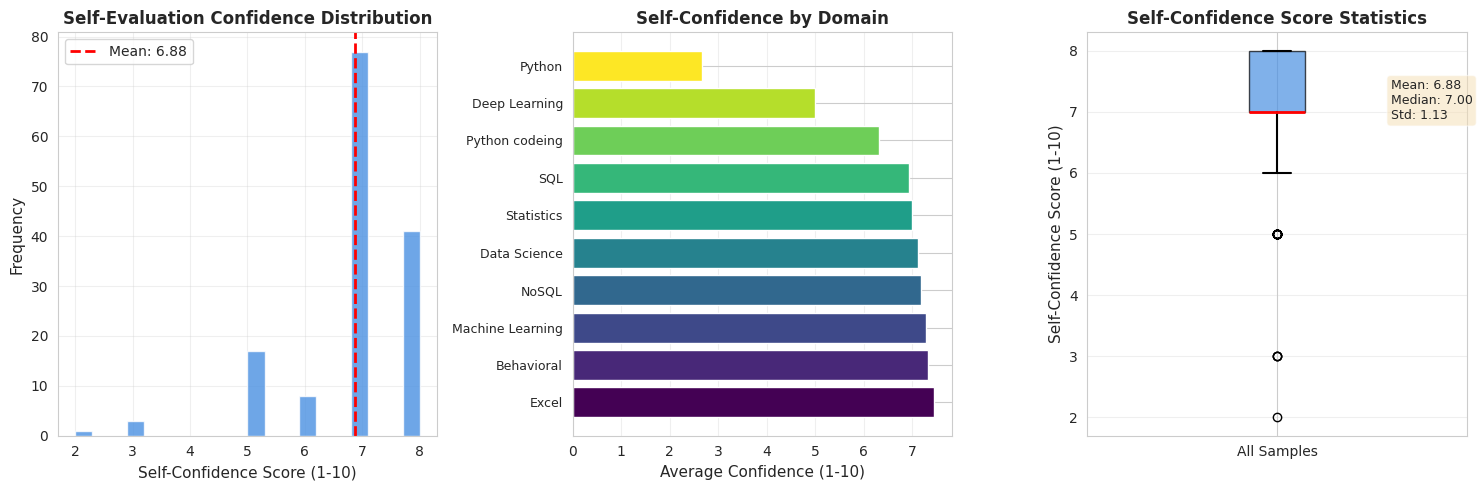


 Generating Human Evaluation Template...
 Human evaluation template generated: /content/qwen_interviewer_work/evaluation_results/human_evaluation_template.csv
   Samples selected: 50

 Instructions for human evaluators:
   1. Open the CSV file in Excel or Google Sheets
   2. For each sample, rate on a scale of 1-5 for each criterion
   3. Provide a FINAL_SCORE (1-5) for overall feedback quality
   4. Add any comments in the 'comments' column
   5. Save the completed file for analysis

 Evaluation Criteria:
   • RELEVANCE: 1 (Not relevant) to 5 (Highly relevant)
   • CONSTRUCTIVENESS: 1 (Not constructive) to 5 (Very constructive)
   • ACCURACY: 1 (Inaccurate) to 5 (Completely accurate)
   • SPECIFICITY: 1 (Very generic) to 5 (Very specific)
   • FOLLOWUP_QUALITY: 1 (Poor) to 5 (Excellent)
   • TONE: 1 (Inappropriate) to 5 (Excellent)
   • FINAL_SCORE: 1 (Poor) to 5 (Excellent)

 Running Baseline Model Comparison...
Comparing on 50 samples...


Generating baseline: 100%|██████████| 50/50 [01:11<00:00,  1.43s/it]



 Baseline Comparison Results:
   Average Fine-tuned Feedback Length: 926.5 chars
   Average Baseline Feedback Length: 557.9 chars

 Results saved to: /content/qwen_interviewer_work/evaluation_results/baseline_comparison.csv

 Sample Comparison:
Question: What are the key differences between SQL and NoSQL databases?...

 Baseline (GPT-2): Question: What do the differences between SQL and NoSQL databases mean for you?

Candidate's Answer: SQL databases do not support a relational database (like a database called a table), and you should...

 Fine-tuned (QWEN): That's correct! Let's dive deeper into some specific aspects.

1. **Schema**: 
   - **SQL Databases** have fixed schemas that define the structure of the data. This ensures consistency across all reco...

  Running LLM as Judge Evaluation...
  This will call OpenAI API 50 times
 Estimated cost: ~$0.50

Type 'yes' to proceed: yes

 Starting evaluation...


Judge evaluating:   0%|          | 0/50 [00:00<?, ?it/s]

 Error calling judge API: 

You tried to access openai.ChatCompletion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742

 Error calling judge API: 

You tried to access openai.ChatCompletion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742



Judge evaluating:   0%|          | 0/50 [00:04<?, ?it/s]

 Error calling judge API: 

You tried to access openai.ChatCompletion, but this is no longer supported in openai>=1.0.0 - see the README at https://github.com/openai/openai-python for the API.

You can run `openai migrate` to automatically upgrade your codebase to use the 1.0.0 interface. 

Alternatively, you can pin your installation to the old version, e.g. `pip install openai==0.28`

A detailed migration guide is available here: https://github.com/openai/openai-python/discussions/742



KeyError: 'judge_rubric'

In [ ]:
test_results = run_complete_evaluation_pipeline()

Above results collected :
1. Perplexity
2. Human Evaluation
3. Baseline model
4. Self Evaluation

Session closed so continuing with rest of results:

5.  LLM as Judge


🔄 Continuing from where we left off...

📂 Checking for existing data...
   Loading baseline_comparison_df from file...
   ✅ Loaded: 50 samples
   Loading test_df from file...
   Loading from original test.jsonl...
   Generating predictions for test set...


Generating: 100%|██████████| 147/147 [38:47<00:00, 15.83s/it]


   ✅ Loaded: 147 samples

✅ Data Ready!
   - Baseline comparison: 50 samples
   - Test predictions: 147 samples

📋 Running remaining evaluations...


  Running LLM as Judge Evaluation...
  This will call OpenAI API 50 times
 Estimated cost: ~$0.50

Type 'yes' to proceed: yes

 Starting evaluation...


Judge evaluating: 100%|██████████| 50/50 [01:44<00:00,  2.09s/it]



 LLM Judge Results:
   Judge Model: gpt-4o-mini
   Samples Evaluated: 50
   Average Judge Score: 7.76 / 10
   Std Deviation: 2.11
   Min Score: 2.0
   Max Score: 10.0

 Score by Domain:
   Statistics: 10.00
   Python codeing: 8.82
   NoSQL: 8.50
   Excel: 8.33
   SQL: 8.29
   Machine Learning: 7.67
   Behavioral: 7.50
   Data Science: 6.42
   Python: 4.00

 Results saved to: /content/qwen_interviewer_work/evaluation_results/judge_scores_openai.csv

 Sample Judge Evaluation:
Question: What are the key differences between SQL and NoSQL databases?...
Answer: SQL databases use structured, tabular data with a predefined schema, while NoSQL...

  Judge Score: 9.0/10
 Judge Reason: The answer accurately describes the key differences in structure and schema between SQL and NoSQL databases.

 Creating visualizations...

 Visualization saved to: /content/qwen_interviewer_work/evaluation_results/baseline_judge_evaluation.png


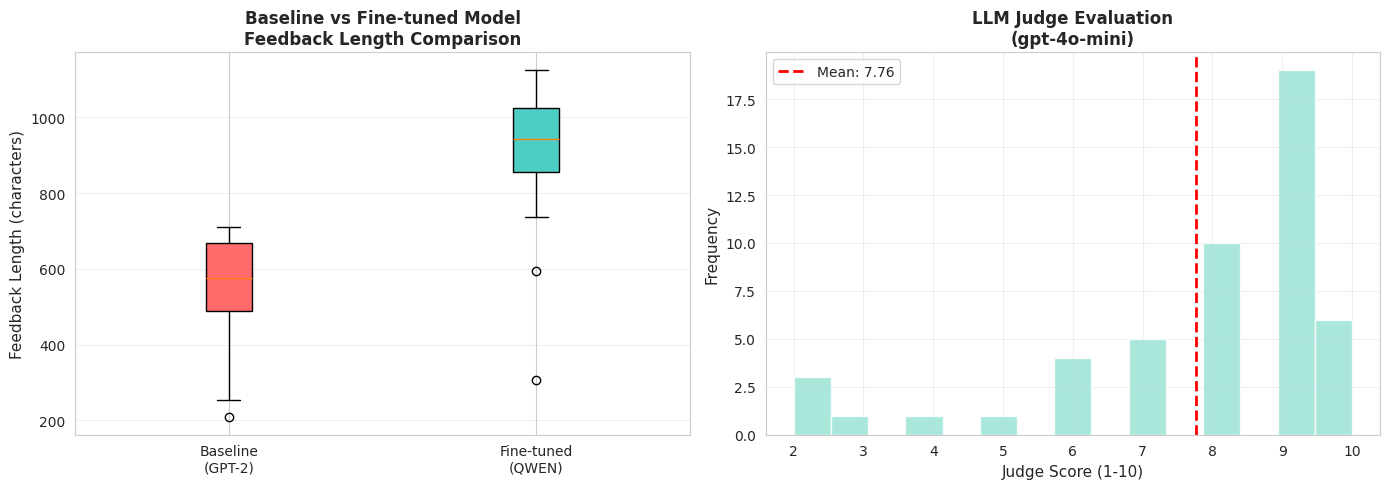


 Generating complete evaluation report...

 COMPLETE EVALUATION REPORT

 EVALUATION METHODS SUMMARY:

1.  Perplexity: Not yet computed
2.   Self-Evaluation: Not yet computed
3.  Human Evaluation: Template generated (pending human input)
4.  Baseline Comparison: 50 samples compared
   Fine-tuned avg length: 927 chars
   Baseline avg length: 558 chars
5.  LLM as Judge (gpt-4o-mini): 7.76 / 10
   Samples evaluated: 50

 Report saved to: /content/qwen_interviewer_work/evaluation_results/complete_evaluation_report.txt

 ALL EVALUATIONS COMPLETE!

 Files generated:
   /content/qwen_interviewer_work/evaluation_results/judge_scores_openai.csv
   /content/qwen_interviewer_work/evaluation_results/baseline_judge_evaluation.png
   /content/qwen_interviewer_work/evaluation_results/complete_evaluation_report.txt
Average Judge Score: 7.76/10


In [ ]:
# ============================================================================
# Run Remaining Evaluations (with data reload if needed)
# ============================================================================

print("Continuing from where we left off...\n")

# STEP 0: Reload data if variables don't exist
print("Checking for existing data...")

# Reload baseline comparison if needed
if 'baseline_comparison_df' not in globals():
    print("   Loading baseline_comparison_df from file...")
    baseline_file = f"{Config.RESULTS_DIR}/baseline_comparison.csv"
    if os.path.exists(baseline_file):
        baseline_comparison_df = pd.read_csv(baseline_file)
        print(f"    Loaded: {len(baseline_comparison_df)} samples")
    else:
        print("    baseline_comparison.csv not found - baseline comparison was not run yet")
        baseline_comparison_df = None
else:
    print(f"    baseline_comparison_df already in memory: {len(baseline_comparison_df)} samples")

# Reload test_df if needed
if 'test_df' not in globals():
    print("   Loading test_df from file...")

    # Try to load from test predictions file first
    test_pred_file = f"{Config.RESULTS_DIR}/test_predictions_complete.csv"
    if os.path.exists(test_pred_file):
        test_df = pd.read_csv(test_pred_file)
        print(f"    Loaded from test_predictions_complete.csv: {len(test_df)} samples")
    else:
        # Fall back to original test file
        print("   Loading from original test.jsonl...")
        test_df = pd.read_json(Config.TEST_FILE, lines=True)

        # Parse messages
        def parse_messages(row):
            messages = row['messages']
            question = messages[1]['content']
            answer = messages[2]['content']
            reference = messages[3]['content']
            domain_match = re.search(r'rigorous (\w+(?:\s+\w+)*) interviewer', messages[0]['content'])
            domain = domain_match.group(1) if domain_match else 'technical'

            return pd.Series({
                'question': question,
                'answer': answer,
                'reference_feedback': reference,
                'domain': domain
            })

        test_df = pd.concat([test_df, test_df.apply(parse_messages, axis=1)], axis=1)

        # Generate predictions if needed
        if 'predicted_feedback' not in test_df.columns:
            print("   Generating predictions for test set...")
            predictions = []
            for idx, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Generating"):
                pred = generate_feedback(
                    model=inference_model,
                    tokenizer=inference_tokenizer,
                    device=device,
                    question=row['question'],
                    answer=row['answer'],
                    domain=row['domain']
                )
                predictions.append(pred)
            test_df['predicted_feedback'] = predictions

        print(f"    Loaded: {len(test_df)} samples")
else:
    print(f"    test_df already in memory: {len(test_df)} samples")

print("\n" + "=" * 70)
print(" Data Ready!")
print("=" * 70)
if baseline_comparison_df is not None:
    print(f"   - Baseline comparison: {len(baseline_comparison_df)} samples")
print(f"   - Test predictions: {len(test_df)} samples")

print("\n Running remaining evaluations...\n")

# STEP 1: Run LLM Judge
judge_evaluation_df = run_llm_judge_evaluation(test_df, sample_size=50)

# STEP 2: Create visualizations
if judge_evaluation_df is not None:
    print("\n Creating visualizations...")
    plot_baseline_and_judge_results(
        baseline_df=baseline_comparison_df,
        judge_df=judge_evaluation_df
    )

# STEP 3: Generate complete report
print("\n Generating complete evaluation report...")
generate_complete_evaluation_report()

print("\n" + "=" * 70)
print(" ALL EVALUATIONS COMPLETE!")
print("=" * 70)

# Show what was generated
print("\n Files generated:")
print(f"   {Config.RESULTS_DIR}/judge_scores_openai.csv")
print(f"   {Config.RESULTS_DIR}/baseline_judge_evaluation.png")
print(f"   {Config.RESULTS_DIR}/complete_evaluation_report.txt")

if judge_evaluation_df is not None:
    print(f"Average Judge Score: {judge_evaluation_df['judge_score'].mean():.2f}/10")